In [1]:
import time
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r'../.././Documents/data/TRAINSET_STOCK.csv')
df['vol_change'] = df.groupby(["ts_code"])['vol'].pct_change()
df['vol_change'] = df['vol_change'].fillna(0)
df.head()

,ts_code,trade_date,name,open,low,high,close,change,pct_change,vol,amount,pe,pb,y,vol_change
0,801010,20140401,农林牧渔,1668.75,1668.54,1689.12,1689.07,22.13,1.33,34914.0,291113.0,41.51,2.77,1,0.000000
1,801010,20140402,农林牧渔,1688.72,1684.53,1693.41,1692.24,3.17,0.19,36300.0,289020.0,41.63,2.79,1,0.039698
2,801010,20140403,农林牧渔,1693.05,1679.85,1697.73,1685.71,-6.53,-0.39,31403.0,259464.0,41.38,2.78,0,-0.134904
3,801010,20140404,农林牧渔,1681.92,1680.34,1698.44,1698.25,12.54,0.74,28648.0,240940.0,41.76,2.80,1,-0.087730
4,801010,20140408,农林牧渔,1693.24,1692.22,1706.84,1706.84,8.59,0.51,35012.0,312423.0,42.00,2.79,1,0.222145


# LSTM

In [29]:
df1 = df[['ts_code','trade_date','name','pct_change','vol_change','y']]
test_df = df.groupby(['trade_date', 'ts_code'])['pct_change']
df2 = df.loc[df1['name']== '交通运输']
def creat_dataset(dataset,look_back=10):
    dataX,dataY = [],[]
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX,np.array(dataY))

In [30]:
dataset = df2['y']
# dataset = pd.DataFrame(dataset)

In [31]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [37]:
x= []
y = []
for i in range(len(dataset)-10):
    x.append(dataset[i:(i+10)])
    y.append(dataset[i+10])
xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.2, random_state=0)
xtrain, xtest, ytrain, ytest = np.array(xtrain),np.array(xtest),np.array(ytrain),np.array(ytest)
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape
xtrain = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], 1))
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], 1))
xtrain.shape

In [33]:
regressor = Sequential()
regressor.add(LSTM(units = 30, return_sequences = True, input_shape = (xtrain.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 30, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 30, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 30))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(xtrain, ytrain, epochs = 100, batch_size = 20)

Epoch 1/100
913/913 [==============================] - 5s 6ms/step - loss: 0.3005
Epoch 2/100
913/913 [==============================] - 2s 2ms/step - loss: 0.2583
Epoch 3/100
913/913 [==============================] - 2s 2ms/step - loss: 0.2556
Epoch 4/100
913/913 [==============================] - 2s 2ms/step - loss: 0.2529
Epoch 5/100
913/913 [==============================] - 2s 2ms/step - loss: 0.2522
Epoch 6/100
913/913 [==============================] - 2s 2ms/step - loss: 0.2562
Epoch 7/100
913/913 [==============================] - 2s 2ms/step - loss: 0.2514
Epoch 8/100
913/913 [==============================] - 2s 2ms/step - loss: 0.2500
Epoch 9/100
913/913 [==============================] - 2s 2ms/step - loss: 0.2540
Epoch 10/100
913/913 [==============================] - 2s 2ms/step - loss: 0.2568
Epoch 11/100
913/913 [==============================] - 2s 2ms/step - loss: 0.2522
Epoch 12/100
913/913 [==============================] - 2s 2ms/step - loss: 0.2526
Epoch 13/100


913/913 [==============================] - 2s 2ms/step - loss: 0.2500
Epoch 100/100
913/913 [==============================] - 2s 2ms/step - loss: 0.2482


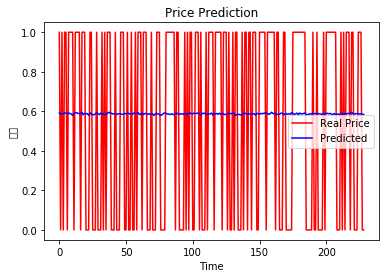

In [34]:
predicted_stock_price = regressor.predict(xtest)
plt.plot(ytest, color = 'red', label = 'Real Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('涨跌')
plt.legend()
plt.show()

In [36]:
np.sqrt(mean_squared_error(predicted_stock_price, ytest))

0.49705494438648723